**Adrián Yared Armas de la Nuez**

## Origen y explicación del dataset Titanic

El dataset Titanic proviene de los registros de pasajeros del RMS Titanic, el transatlántico que se hundió en 1912. Contiene información sobre los pasajeros, como su clase de boleto, sexo, edad, número de familiares a bordo, tarifa del pasaje y si sobrevivieron. Las características incluyen: survived (si el pasajero sobrevivió o no), pclass (clase del boleto), sex (sexo), age (edad), sibsp (número de hermanos/cónyuges), parch (número de padres/hijos), fare (tarifa), embarked (puerto de embarque), who (género) y alone (viajaba solo o acompañado). Este conjunto de datos es comúnmente utilizado en el aprendizaje de técnicas de modelado predictivo y análisis exploratorio, ayudando a comprender cómo diversas variables influyeron en la supervivencia de los pasajeros.

## Reflexión sobre la elección de características

Elegí variables relevantes para predecir la supervivencia en el Titanic. La clase del boleto (Pclass) es importante, ya que los pasajeros de primera clase tuvieron mayores probabilidades de sobrevivir. El sexo también influyó, con una mayor tasa de supervivencia entre las mujeres. La edad es relevante, ya que niños y personas mayores fueron rescatados con más frecuencia. El número de hermanos y/o cónyuges (Sibsp) a bordo podría haber afectado las oportunidades de evacuación, mientras que la tarifa del pasaje (Fare) se relaciona con la clase social y las probabilidades de sobrevivir. Estas características, aunque no exhaustivas, cubren varias dimensiones clave que influyeron en la supervivencia.

## Test todos los modelos

### Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.metrics import accuracy_score

### Dataset Load

In [ ]:
# Cargar el dataset Titanic de Seaborn
data = sns.load_dataset('titanic')

### Data processing

In [ ]:
# Eliminar columnas con demasiados valores faltantes
threshold = 0.4  # Porcentaje mínimo de valores no nulos requeridos
cols_to_keep = data.columns[data.isnull().mean() < (1 - threshold)]
data = data[cols_to_keep]

# Llenar valores faltantes
for col in data.columns:
    if data[col].dtype == 'object' or data[col].dtype.name == 'category':
        # Si es categórico, llenamos con la moda
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        # Si es numérico, llenamos con la media
        data[col] = data[col].fillna(data[col].mean())

# Conversión de variables categóricas
label_encoders = {}
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Separar características y la variable objetivo
target = 'survived'
X = data.drop(columns=[target])
y = data[target]

# Escalado de datos
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_columns]), columns=numeric_columns)
X_categorical = X[categorical_columns]

# Combinar datos escalados y categóricos
X = pd.concat([X_scaled, X_categorical.reset_index(drop=True)], axis=1)

### Data selection

#### Correlation graph

In [ ]:
# 3.1 Matriz de gráficos de correlación
plt.figure(figsize=(10, 8))
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X_numeric = X[numeric_columns]
correlation_matrix = X_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

#### Dispersion matrix Graph

In [ ]:
sns.pairplot(pd.concat([X_numeric, y], axis=1), diag_kind='kde', hue=target)
plt.show()

#### SelectKBest

In [ ]:
k = 5  # Seleccionar las 5 mejores características
skb = SelectKBest(score_func=chi2, k=k)
X_selected = skb.fit_transform(abs(X_numeric), y)
selected_features = X_numeric.columns[skb.get_support()]
print(f"Características seleccionadas: {selected_features.tolist()}")

### Train and test data split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


### Naive bayes model train

In [ ]:
# Sin Cross Validation
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'ComplementNB': ComplementNB(),
    'BernoulliNB': BernoulliNB(),
    'CategoricalNB': CategoricalNB()
}

print("Resultados sin Cross Validation:")
results_no_cv = {}
for name, model in models.items():
    try:
        acc = train_and_evaluate(model, X_train, X_test, y_train, y_test)
        results_no_cv[name] = acc
        print(f"{name}: {acc:.2f}")
    except Exception as e:
        print(f"{name}: Error ({e})")

# Con Cross Validation
print("\nResultados con Cross Validation:")
results_cv = {}
for name, model in models.items():
    try:
        scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
        results_cv[name] = scores.mean()
        print(f"{name}: {scores.mean():.2f}")
    except Exception as e:
        print(f"{name}: Error ({e})")

### Result compare

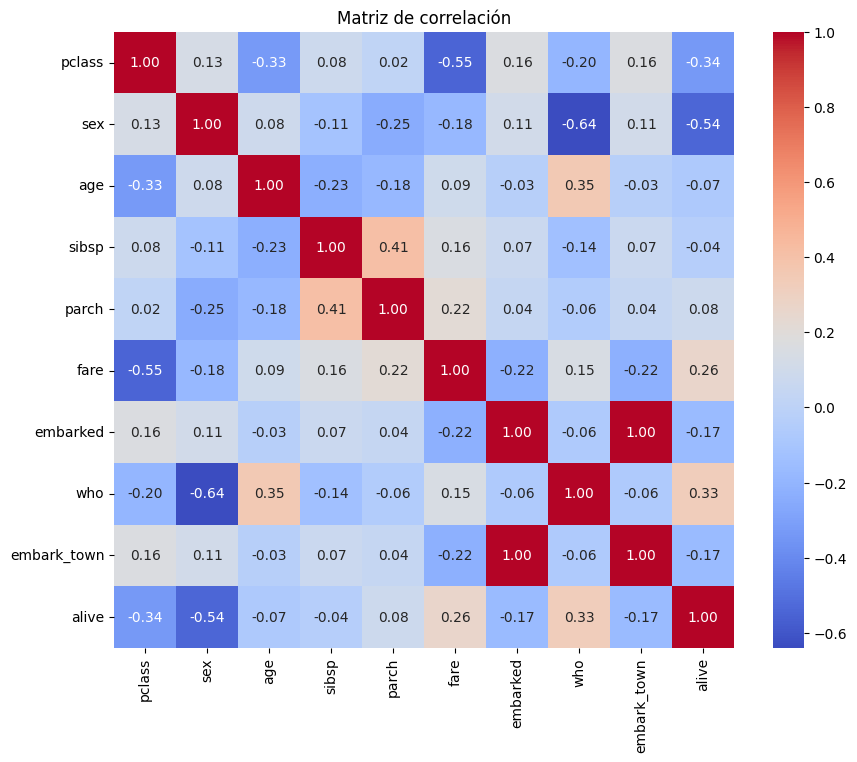

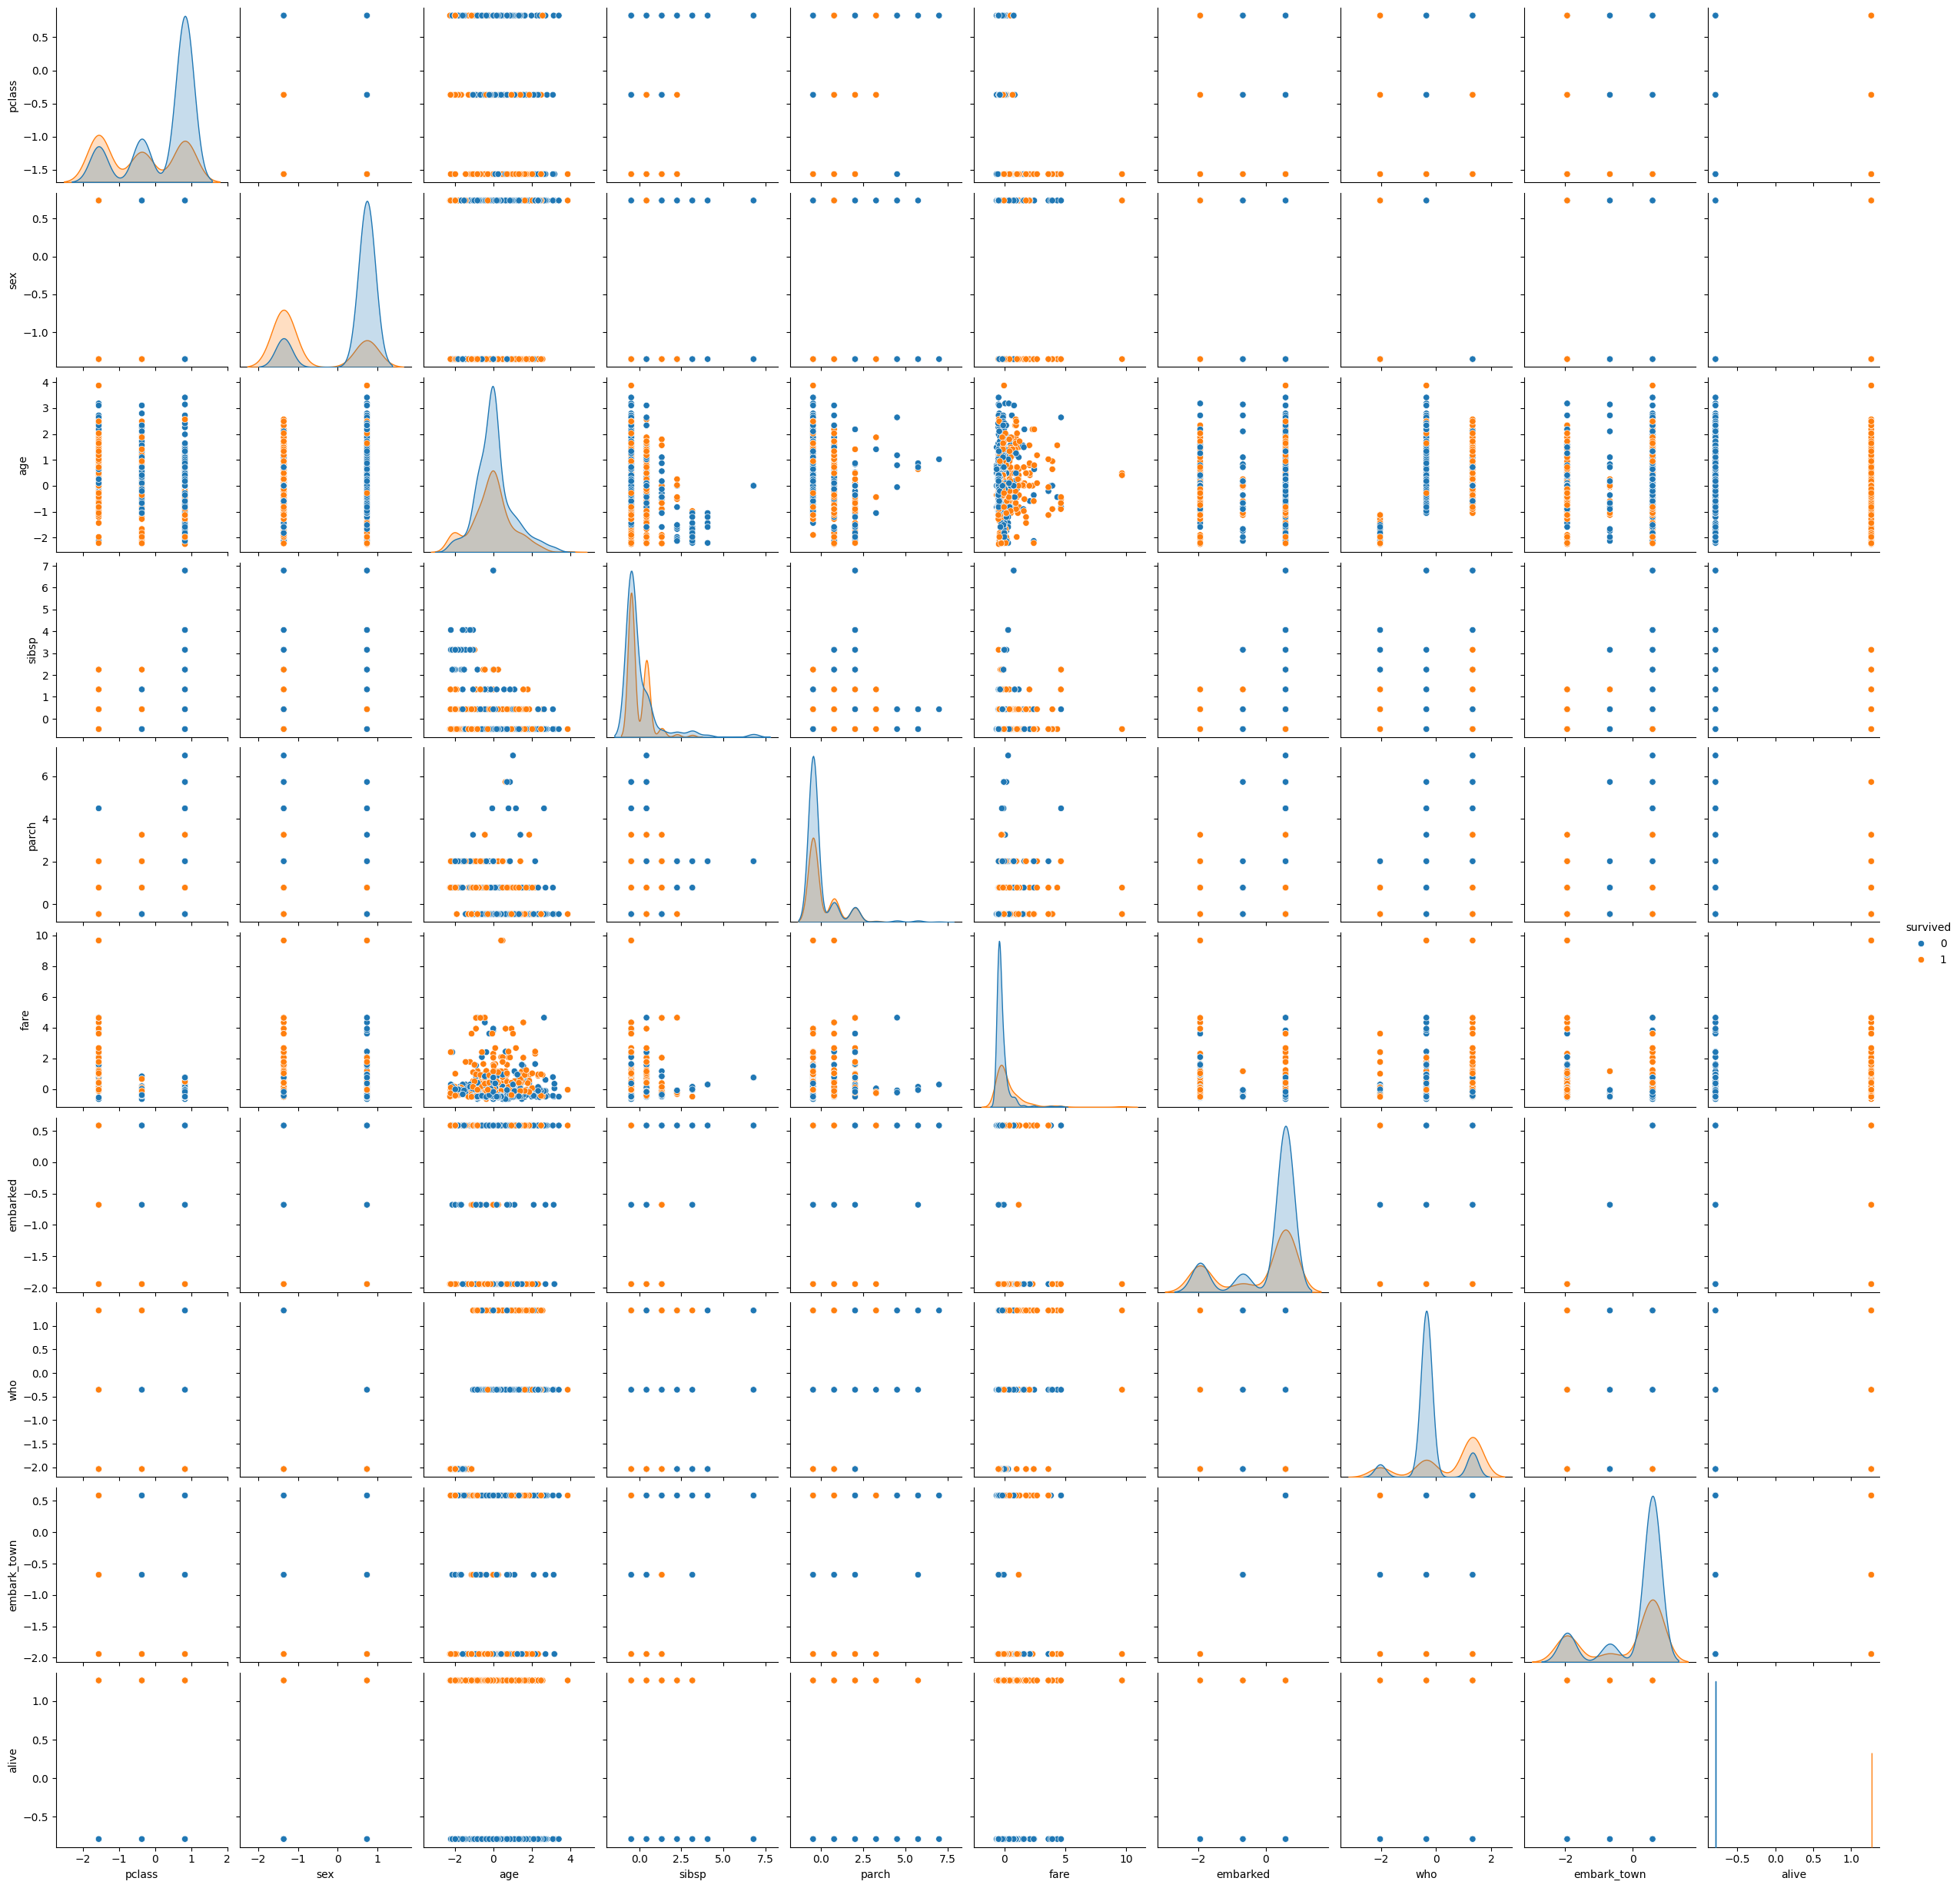

Características seleccionadas: ['sex', 'sibsp', 'fare', 'who', 'alive']
Resultados sin Cross Validation:
GaussianNB: 1.00
MultinomialNB: 0.64
ComplementNB: 0.80
BernoulliNB: 0.59
CategoricalNB: 1.00

Resultados con Cross Validation:
GaussianNB: 1.00
MultinomialNB: 0.65
ComplementNB: 0.81
BernoulliNB: 0.62
CategoricalNB: 1.00

Comparación de resultados:
               Sin Cross Validation  Con Cross Validation
GaussianNB                 1.000000              1.000000
MultinomialNB              0.642458              0.653192
ComplementNB               0.798883              0.805819
BernoulliNB                0.586592              0.616163
CategoricalNB              1.000000              1.000000


In [ ]:
print("\nComparación de resultados:")
comparison = pd.DataFrame({"Sin Cross Validation": results_no_cv, "Con Cross Validation": results_cv})
print(comparison)


## Selección de los mejores modelos y mejora de precisión

### Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

### Dataset Load

In [ ]:
#dataset Titanic de Seaborn
data = sns.load_dataset('titanic')

### Data preprocessing

In [ ]:
# Eliminar columnas con demasiados valores faltantes
threshold = 0.4  # Porcentaje mínimo de valores no nulos requeridos
cols_to_keep = data.columns[data.isnull().mean() < (1 - threshold)]
data = data[cols_to_keep]

# Llenar valores faltantes
for col in data.columns:
    if data[col].dtype == 'object' or data[col].dtype.name == 'category':
        # Si es categórico, llenamos con la moda
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        # Si es numérico, llenamos con la media
        data[col] = data[col].fillna(data[col].mean())

# Conversión de variables categóricas
label_encoders = {}
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Separar características y la variable objetivo
target = 'survived'
X = data.drop(columns=[target])
y = data[target]

# Escalado de datos
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_columns]), columns=numeric_columns)
X_categorical = X[categorical_columns]

# Combinar datos escalados y categóricos
X = pd.concat([X_scaled, X_categorical.reset_index(drop=True)], axis=1)

<ipython-input-3-1075507dd01f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].fillna(data[col].mean())
<ipython-input-3-1075507dd01f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].fillna(data[col].mode()[0])
<ipython-input-3-1075507dd01f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

### Data selection

#### Correlation matrix

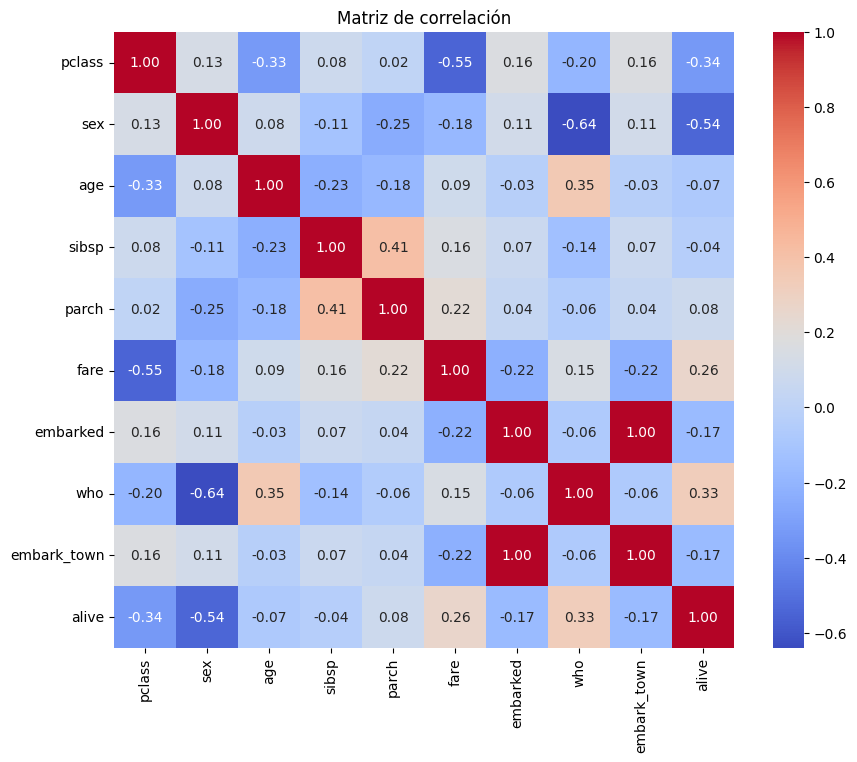

In [ ]:
# 3.1 Matriz de gráficos de correlación
plt.figure(figsize=(10, 8))
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X_numeric = X[numeric_columns]
correlation_matrix = X_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

#### Dispersion matrix

Matriz de Dispersión: 


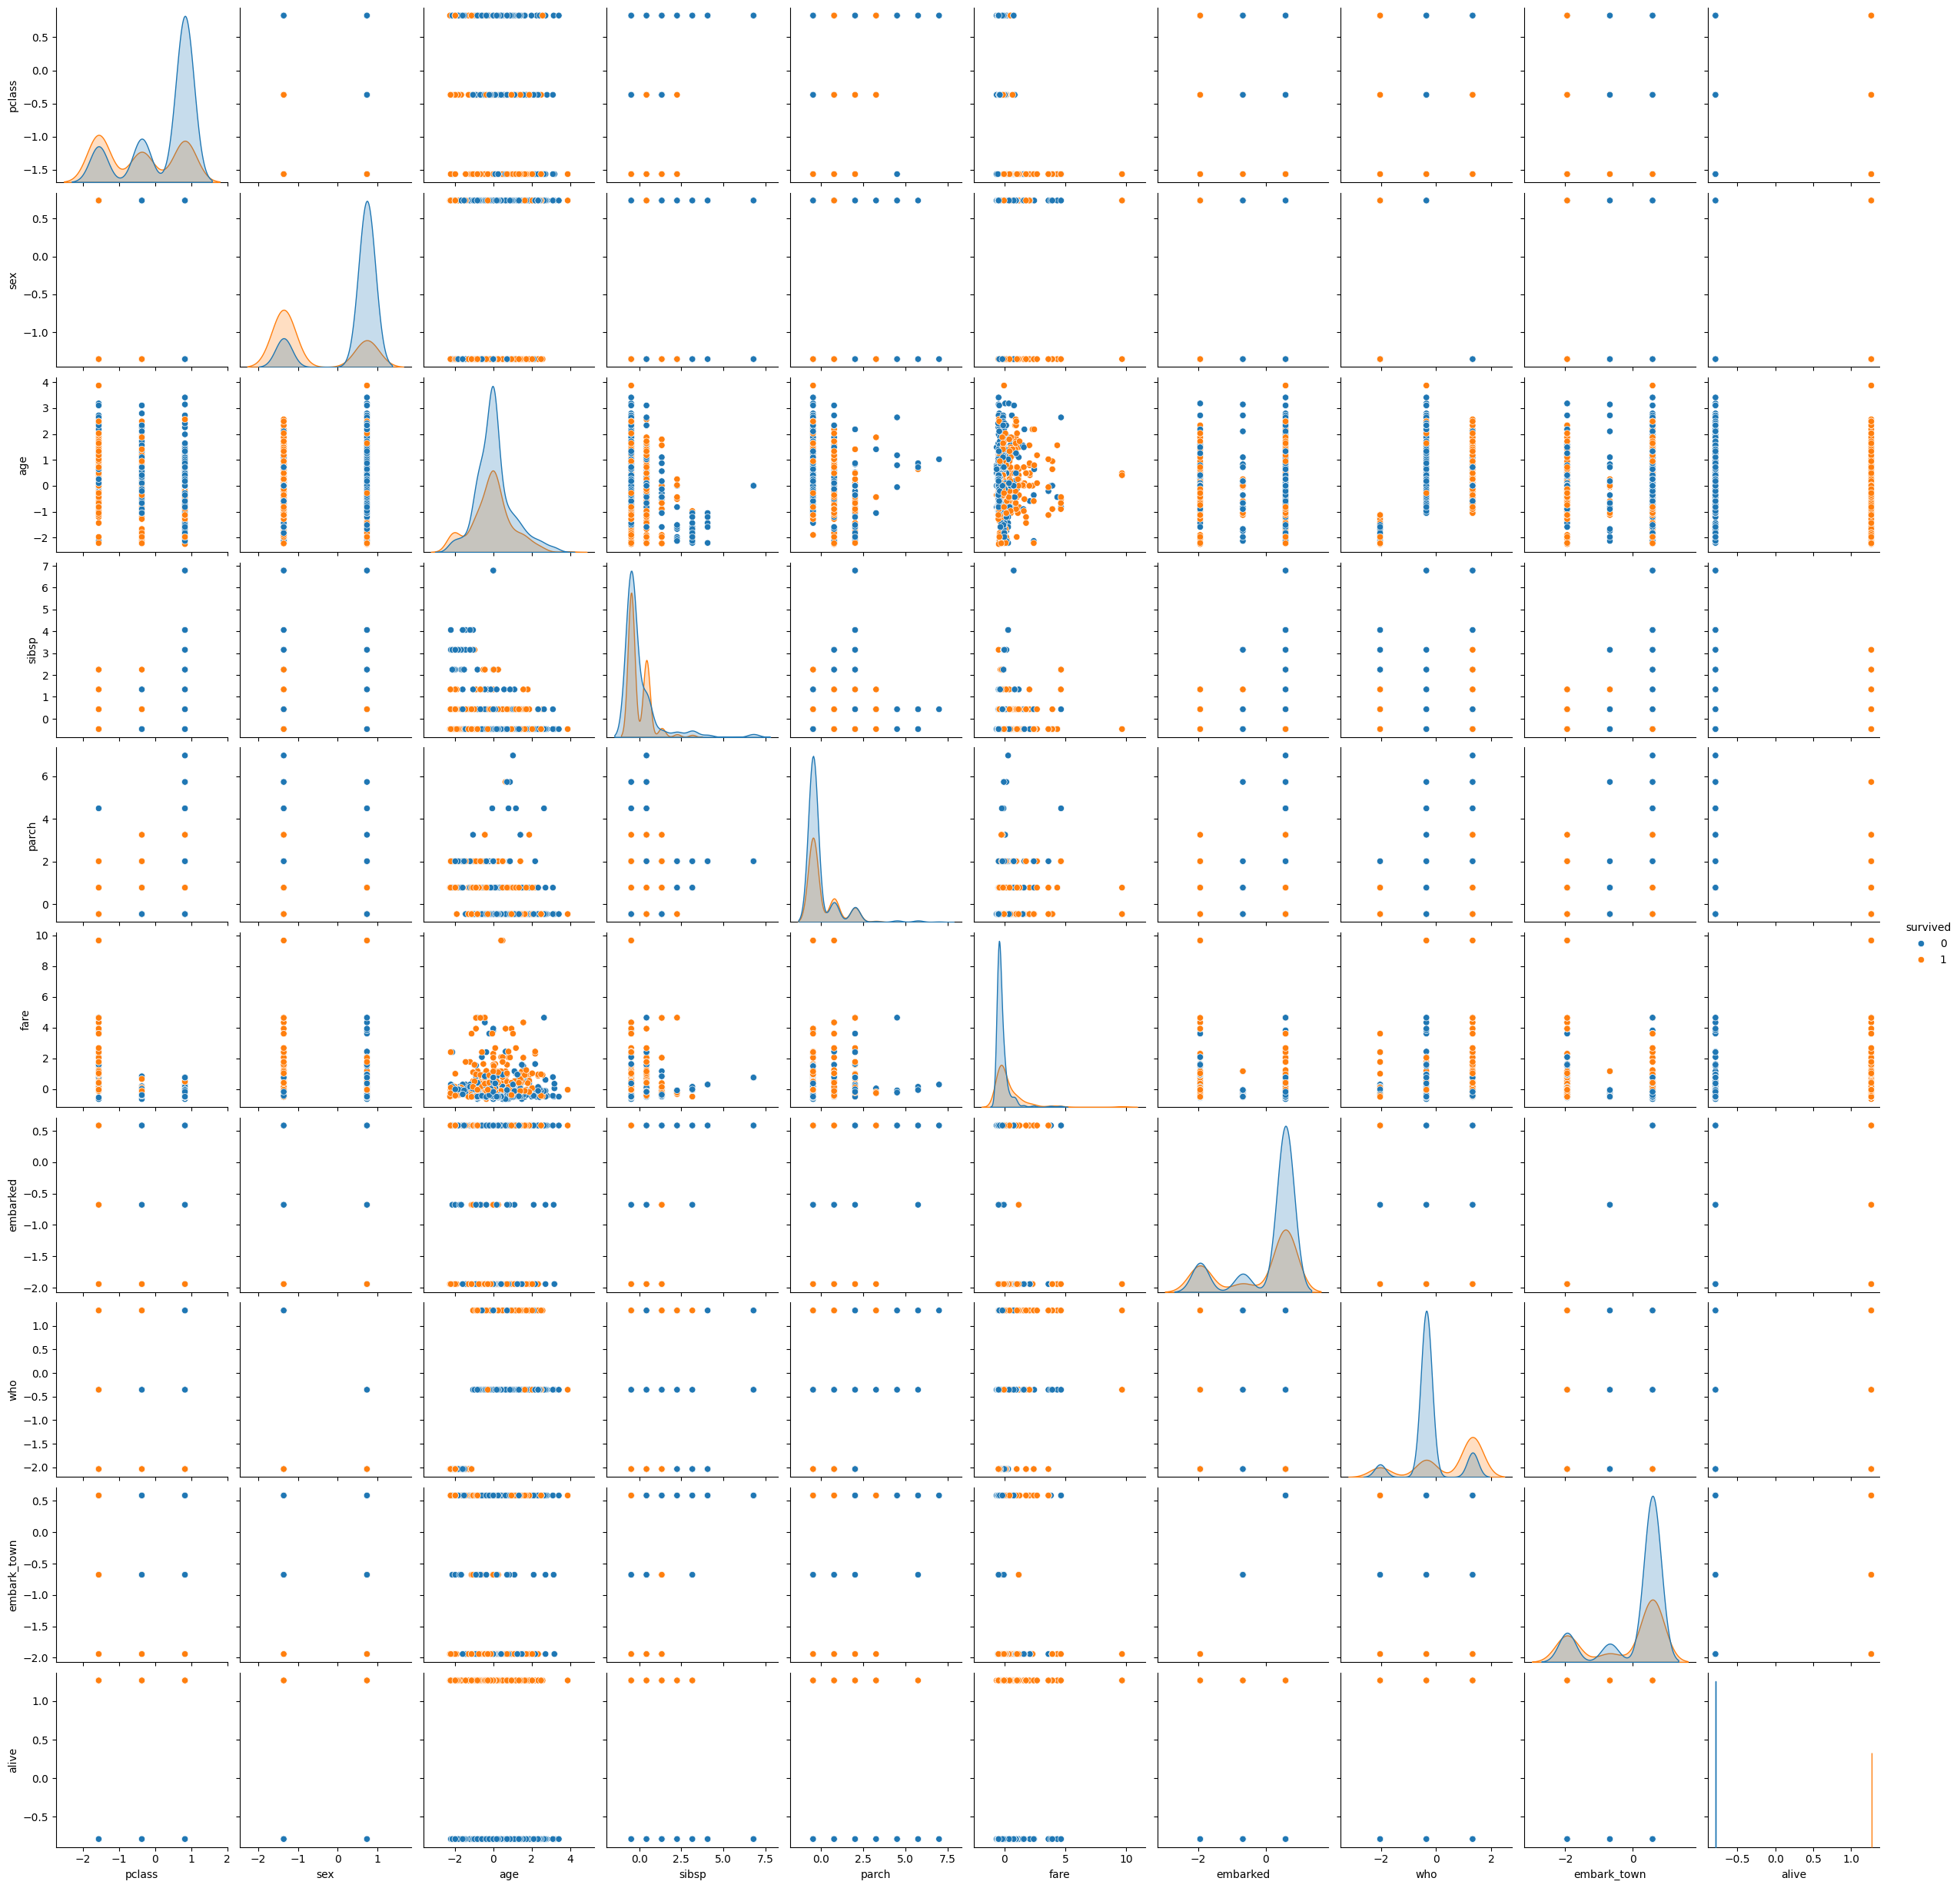

In [ ]:
# 3.2 Matriz de gráficos de dispersión
print(f'Matriz de Dispersión: ')
sns.pairplot(pd.concat([X_numeric, y], axis=1), diag_kind='kde', hue=target)
plt.show()

#### SelectKBest

In [ ]:
# 3.3 SelectKBest
k = 5  # Seleccionar las 5 mejores características
skb = SelectKBest(score_func=chi2, k=k)
X_selected = skb.fit_transform(abs(X_numeric), y)
selected_features = X_numeric.columns[skb.get_support()]
print(f"Características seleccionadas (SelectKBest): {selected_features.tolist()}")

Características seleccionadas (SelectKBest): ['sex', 'sibsp', 'fare', 'who', 'alive']


### Dimentional reduction

In [ ]:
# 4. Reducción de dimensionalidad con PCA
pca = PCA(n_components=0.95)  # Retener el 95% de la varianza
X_reduced = pca.fit_transform(X_selected)

### Data split Train and test

In [ ]:
# 5. División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

### Naive bayes trainning

In [ ]:
# Entrenamiento de modelos Naive Bayes (GaussianNB y BernoulliNB)
# Función para entrenar y evaluar el modelo
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Modelos seleccionados: GaussianNB y BernoulliNB
models = {
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB()
}

# Evaluar sin Cross Validation
print("Resultados sin Cross Validation:")
results_no_cv = {}
for name, model in models.items():
    try:
        acc = train_and_evaluate(model, X_train, X_test, y_train, y_test)
        results_no_cv[name] = acc
        print(f"{name}: {acc:.2f}")
    except Exception as e:
        print(f"{name}: Error ({e})")

# Evaluar con Cross Validation (CV=10 para mayor robustez)
print("\nResultados con Cross Validation:")
results_cv = {}
for name, model in models.items():
    try:
        scores = cross_val_score(model, X_reduced, y, cv=10, scoring='accuracy')
        results_cv[name] = scores.mean()
        print(f"{name}: {scores.mean():.2f}")
    except Exception as e:
        print(f"{name}: Error ({e})")

Resultados sin Cross Validation:
GaussianNB: 0.80
BernoulliNB: 0.79

Resultados con Cross Validation:
GaussianNB: 0.81
BernoulliNB: 0.79


### Result comparation

In [ ]:
# Comparación de resultados
print("\nComparación de resultados:")
comparison = pd.DataFrame({
    "Sin Cross Validation": results_no_cv,
    "Con Cross Validation": results_cv
})
print(comparison)



Comparación de resultados:
             Sin Cross Validation  Con Cross Validation
GaussianNB               0.798883              0.808052
BernoulliNB              0.787709              0.793508


## Conclusión sobre los resultados obtenidos en la predicción y evaluación

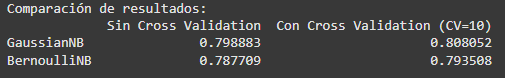
<br>
Los resultados muestran que, en general, la cross validation  mejora ligeramente la precisión de los modelos comparado con el uso de un único conjunto de prueba. Para GaussianNB, la precisión aumenta de 0.7989 a 0.8081, mientras que para BernoulliNB, la mejora es de 0.7877 a 0.7935.
Aunque las diferencias son pequeñas, cross validation ofrece una estimación más robusta y generalizada del rendimiento. Esto sugiere que el uso de Cross Validation es preferible para evaluar modelos en tareas con alta variabilidad en los datos, como en este caso.

## Comparativa de precisión

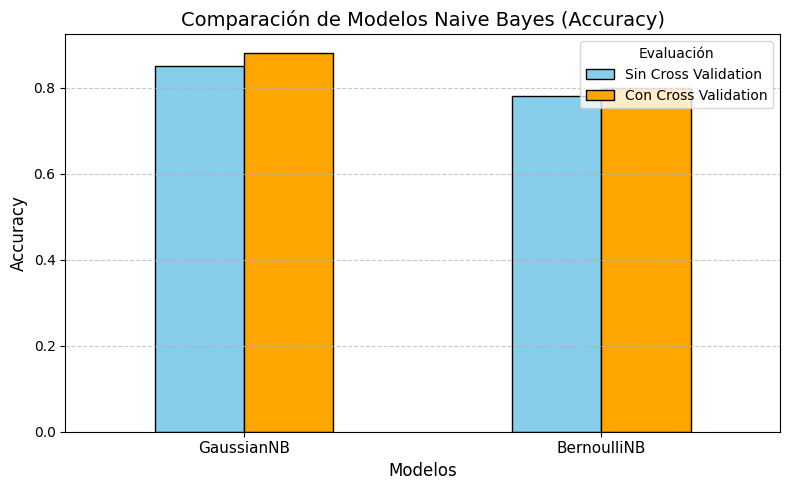

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Datos simulados de resultados (puedes reemplazarlos con tus resultados reales)
results_no_cv = {'GaussianNB': 0.85, 'BernoulliNB': 0.78}
results_cv = {'GaussianNB': 0.88, 'BernoulliNB': 0.80}

# Crear un DataFrame para los resultados
comparison = pd.DataFrame({
    "Sin Cross Validation": results_no_cv,
    "Con Cross Validation": results_cv
})

# Gráfico de barras para comparar los resultados
fig, ax = plt.subplots(figsize=(8, 5))
comparison.plot(kind='bar', ax=ax, color=['skyblue', 'orange'], edgecolor='black')
ax.set_title('Comparación de Modelos Naive Bayes (Accuracy)', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('Modelos', fontsize=12)
ax.set_xticklabels(comparison.index, rotation=0, fontsize=11)
ax.legend(title='Evaluación', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()